<a href="https://colab.research.google.com/github/shahma123/codec/blob/main/stock/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3174194686.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.df = yf.download(self.ticker, start=self.start_date, end=self.end_date)
[*********************100%***********************]  1 of 1 completed

Fetching data for AAPL...
Data fetched successfully.
Training model on 383 data points...
Model trained.

Model Coefficients:
('Prev_Close', ''): 1.0542
('MA_5', ''): -0.1172
('MA_20', ''): 0.0496

Model Evaluation:
Root Mean Squared Error (RMSE): 3.26
R^2 Score: 0.96


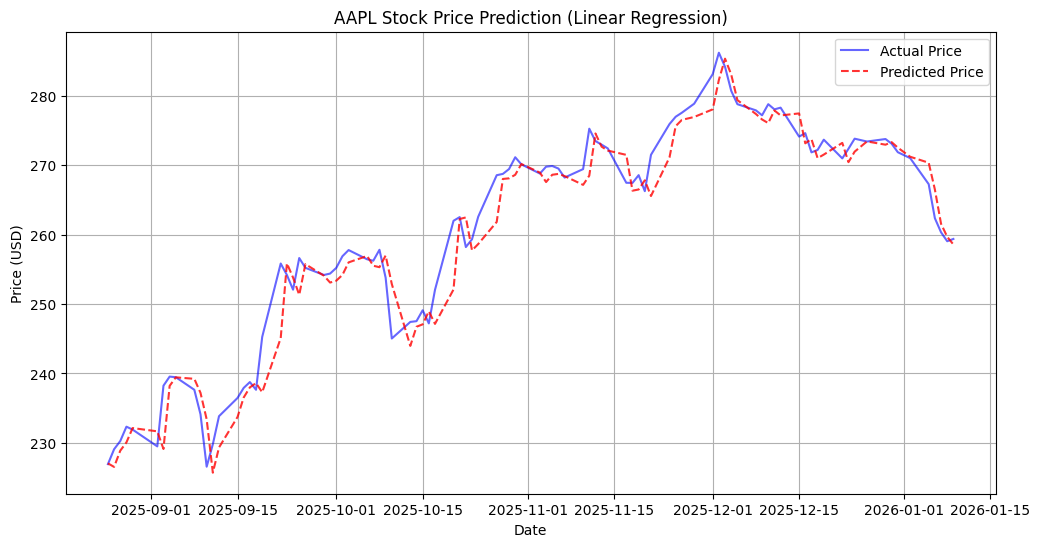


Note: To predict tomorrow's price specifically, you would feed the most recent 'Close', 'MA_5', and 'MA_20' into predictor.model.predict()


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class StockPredictor:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.model = LinearRegression()
        self.df = None
        self.X_test = None
        self.y_test = None
        self.predictions = None

    def fetch_data(self):
        """Downloads historical data using yfinance."""
        print(f"Fetching data for {self.ticker}...")
        self.df = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        if self.df.empty:
            raise ValueError("No data found for the given ticker.")
        print("Data fetched successfully.")

    def prepare_data(self):
        """
        Feature Engineering:
        We will use the 'Close' price of the current day to predict the 'Close' price
        of the NEXT day. We can also add Moving Averages as features.
        """
        data = self.df.copy()

        # Create features (X)
        # 1. Previous Day's Close
        data['Prev_Close'] = data['Close']
        # 2. 5-Day Moving Average
        data['MA_5'] = data['Close'].rolling(window=5).mean()
        # 3. 20-Day Moving Average
        data['MA_20'] = data['Close'].rolling(window=20).mean()

        # Create Target (y)
        # We want to predict the 'Close' price of the NEXT day
        data['Target'] = data['Close'].shift(-1)

        # Drop NaN values created by rolling windows and shifting
        data = data.dropna()

        # Define features and target
        feature_cols = ['Prev_Close', 'MA_5', 'MA_20']
        X = data[feature_cols]
        y = data['Target']

        return X, y, data.index

    def train(self):
        """Trains the Linear Regression model."""
        X, y, dates = self.prepare_data()

        # Split into training and testing sets (80% train, 20% test)
        # We don't shuffle because this is time-series data
        X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        print(f"Training model on {len(X_train)} data points...")
        self.model.fit(X_train, y_train)
        print("Model trained.")

        # Coefficients
        print("\nModel Coefficients:")
        for feature, coef in zip(X.columns, self.model.coef_):
            print(f"{feature}: {coef:.4f}")

    def evaluate(self):
        """Evaluates the model and predicts on test set."""
        self.predictions = self.model.predict(self.X_test)

        mse = mean_squared_error(self.y_test, self.predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(self.y_test, self.predictions)

        print("\nModel Evaluation:")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"R^2 Score: {r2:.2f}")

    def visualize(self):
        """Plots the actual vs predicted prices."""
        plt.figure(figsize=(12, 6))

        # We need to map the test data back to their dates
        # Since we didn't shuffle, the test data is the last chunk
        test_dates = self.df.index[-len(self.y_test):]

        plt.plot(test_dates, self.y_test, label='Actual Price', color='blue', alpha=0.6)
        plt.plot(test_dates, self.predictions, label='Predicted Price', color='red', linestyle='--', alpha=0.8)

        plt.title(f'{self.ticker} Stock Price Prediction (Linear Regression)')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    # --- Configuration ---
    TICKER = "AAPL"  # Change to any stock symbol (e.g., GOOGL, MSFT, TSLA)
    START_DATE = (datetime.now() - timedelta(days=365*2)).strftime('%Y-%m-%d') # 2 years of data
    END_DATE = datetime.now().strftime('%Y-%m-%d')

    try:
        predictor = StockPredictor(TICKER, START_DATE, END_DATE)
        predictor.fetch_data()
        predictor.train()
        predictor.evaluate()
        predictor.visualize()

        # Example: Predict for tomorrow (using the very last known data)
        # Note: In a real scenario, you'd need the latest live data point
        last_row = predictor.df.iloc[-1]
        # We need to reconstruct the features manually for the latest point
        # This is a simplification; for production, recalculate MAs properly
        print("\nNote: To predict tomorrow's price specifically, you would feed the most recent 'Close', 'MA_5', and 'MA_20' into predictor.model.predict()")

    except Exception as e:
        print(f"An error occurred: {e}")